# Demo to use sequential to build ANN model
Here the demo uses class method to build a simple ANN model to classify a multi-class dataset. The classification has a good accuracy of 93.67%. 

By using class method it is more flexible than the nn.Sequence().

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

### 1. define the data

Text(0, 0.5, 'feature 2')

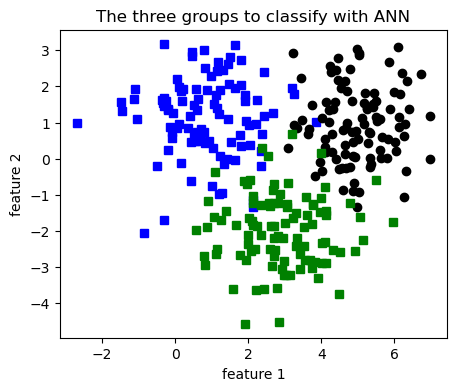

In [26]:
# create the data
nPerClust = 100
blur = 1

A = [  1, 1 ]
B = [  5, 1 ]
C = [  3, -2]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# concatenate the data and labels from the 3 groups
data_np = np.hstack((a, b, c)).T
labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 2*np.ones((nPerClust))))

# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# plot the data
fig = plt.figure(figsize=(5,4))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko')
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'gs')
plt.title('The three groups to classify with ANN')
plt.xlabel('feature 1')
plt.ylabel('feature 2')


### 2. Build the model

In [27]:
# build the model 
class ANNClassify(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_units, n_layers):
        super().__init__()
        self.n_layers = n_layers

        # create special ModuleDict to save the linear layer info input, hidden layer and output
        self.layers = nn.ModuleDict()
        # populate the ModuleDict layer info
        self.layers['input'] = nn.Linear(n_inputs, n_units)
        for i in range(n_layers):
            self.layers[f'hidden{i}'] = nn.Linear(n_units, n_units)
        self.layers['output'] = nn.Linear(n_units, n_outputs)
    
    def forward(self, x):
        # input layer
        x = self.layers['input'](x)
        x = F.relu(x)
        # hidden layers
        for i in range(self.n_layers):
            x = self.layers[f'hidden{i}'](x)
            x = F.relu(x)
        # output layer
        x = self.layers['output'](x)
        return x

In [28]:
n_inputs = 2
n_outputs = 3
n_units = 8
n_layers = 1
net = ANNClassify(n_inputs, n_outputs, n_units, n_layers)

# do sanity checks on your defined network
print(net)
print(net(torch.randn(10, n_inputs)).shape)

ANNClassify(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=8, bias=True)
    (hidden0): Linear(in_features=8, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=3, bias=True)
  )
)
torch.Size([10, 3])


### 3. Train the model

In [29]:
def train_model(data, y_label, model, lr=0.01, n_epochs=1000):
    '''trains a deep learning model'''
    # define metaparameters
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # create an historical performance list
    loss_history = torch.zeros(n_epochs)
    accuracy_history = np.zeros(n_epochs)

    # start the training
    for epoch_i in range(n_epochs):
        # forward pass
        y_hat = model(data)
        # compute loss
        loss = loss_fun(y_hat, y_label)
        loss_history[epoch_i] = loss
        # backpropagation
        # need to zero the gradient every epoch bc by default the gradient accumulates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate the accuracy and save to historical array
        accuracy_history[epoch_i] = torch.mean((torch.argmax(y_hat, axis=1) == y_label).float())
    return {'model': model, 'loss_history': loss_history, 'accuracy_history': accuracy_history}

In [33]:
lr = 0.01
n_epochs = 3000
results = train_model(data, labels, net, lr, n_epochs)
net, loss_history, accuracy_history = results['model'], results['loss_history'], results['accuracy_history']
print('accuracy is: ', accuracy_history[-1])

0.949999988079071


### 4. Visualizing the results

Text(0.5, 1.0, 'Accuracy over epochs')

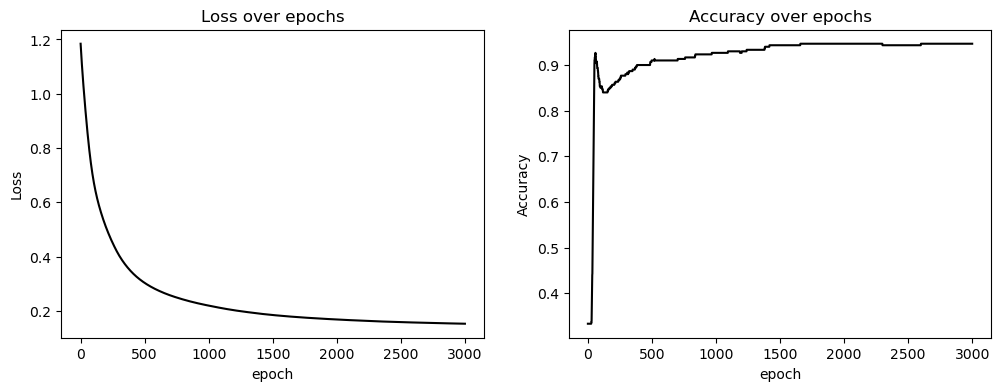

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(loss_history.detach(), 'k')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss over epochs')
ax[1].plot(accuracy_history, 'k')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy over epochs')

### 5. check out the parameters

In [32]:
for i in net.named_parameters():
    print(i)

('layers.input.weight', Parameter containing:
tensor([[ 0.1566,  0.5790],
        [ 0.5981, -0.1877],
        [ 0.4196,  0.6960],
        [-0.1669,  0.5526],
        [ 0.6493,  0.7796],
        [-0.2104,  0.5412],
        [ 1.1229, -0.1785],
        [ 0.4236, -0.7399]], requires_grad=True))
('layers.input.bias', Parameter containing:
tensor([ 0.9467, -0.3353,  0.5762,  0.9250,  0.1711,  0.1893, -0.0794,  0.8994],
       requires_grad=True))
('layers.hidden0.weight', Parameter containing:
tensor([[-0.0204,  0.4964,  0.0459, -0.5978,  0.5446, -0.2909,  0.5932, -0.0843],
        [ 0.1555,  0.3016,  0.3860, -0.5286,  0.1815, -0.2779,  0.5110, -0.4415],
        [ 0.3356, -0.0683,  0.4438,  0.0382, -0.1932,  0.4559,  0.0790, -0.1080],
        [-0.3165,  0.1076,  0.1225, -0.2476, -0.2801, -0.0175,  0.0447, -0.0159],
        [ 0.1451,  0.0582, -0.2805, -0.1789,  0.0517, -0.0024, -0.1260, -0.2833],
        [-0.1160,  0.1023, -0.1674,  0.4183, -0.5134, -0.2994,  0.5869,  0.8795],
        [-0.358